# Comparison of online CCA algorithms

### Imports

In [40]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import time

from cca_algorithms import bio_cca, gen_oja, msg_cca, asy_cca, bio_rrr
from CCAPyramidal import CCAPyramidal
from util import correlation_matrix, obj_error, msg_error, subspace_error, constraint_error, add_fill_lines

### Load dataset

In [41]:
# select the desired dataset and number of epochs

dataset = 'synthetic'; epochs = 1
# dataset = 'mediamill'; epochs = 3

# load dataset

X = np.load(f'datasets/{dataset}/view1.npy')
Y = np.load(f'datasets/{dataset}/view2.npy')

# dataset dimensions

x_dim = X.shape[0]
y_dim = Y.shape[0]
samples = X.shape[1]

### Offline solution

In [42]:
# Covariance matrices

Cxx = X@X.T/samples
Cyy = Y@Y.T/samples
Cxy = X@Y.T/samples

# Inverse matrices

sig_y, Uy = np.linalg.eig(Cyy)

Cyy_inv = Uy@np.diag(1./sig_y)@Uy.T

# Correlation matrix

Rxy = correlation_matrix(Cxx, Cyy, Cxy)

# SVD

u, canonical_correlations, vh = np.linalg.svd(Rxy)

### Online algorithms

In [43]:
# Parameters

trials = 5; z_dim = 2; iters = epochs*samples; training_samples = 1000

In [44]:
# Maximum of the objective

max_obj = sum(canonical_correlations[:z_dim])/2

In [45]:
# Optimal subspace projections

Ux = u[:,:z_dim]
Uy = vh.T[:,:z_dim]

Px_opt = Ux@np.linalg.inv(Ux.T@Ux)@Ux.T
Py_opt = Uy@np.linalg.inv(Uy.T@Uy)@Uy.T

In [46]:
# Specify which algorithms to run

algorithms = []

algorithms.append('Bio-CCA')
algorithms.append('MSG-CCA')
if z_dim==1: algorithms.append('Gen-Oja')
algorithms.append('Asymmetric-CCA')
algorithms.append('Bio-RRR')

In [47]:
alg_error = {}
alg_subspacex_error = {}
alg_time = {}

for alg in algorithms:
    alg_time[alg] = np.zeros((trials,iters))
    if alg!='Bio-RRR':
        alg_error[alg] = np.zeros((trials,iters))
    if alg!='MSG-CCA':
        alg_subspacex_error[alg] = np.zeros((trials,iters))
    
if 'Bio-CCA' in algorithms:
    biocca_constraint_error = np.zeros((trials,iters))

In [48]:
start_time = time.time()

for i_trial in range(trials):
    
    print(f'Trial {i_trial+1} out of {trials}:')
                
    # Initialize Bio-CCA
    
    if 'Bio-CCA' in algorithms:
        biocca = bio_cca(z_dim,x_dim,y_dim,dataset)   
        biocca_Vx = np.zeros((iters,x_dim,z_dim))
        biocca_Vy = np.zeros((iters,y_dim,z_dim))
    
    # Initialize MSG-CCA
    
    if 'MSG-CCA' in algorithms:
        msgcca = msg_cca(z_dim,x_dim,y_dim)
        msgcca_M = np.zeros((iters,x_dim,y_dim))
    
    # Initialize Asymmetric-CCA
        
    if 'Asymmetric-CCA' in algorithms:
        if dataset=='synthetic': asycca = CCAPyramidal(X,Y,k=z_dim,eta={"W":0.0002,"V":0.0002,"M":0.0002,"Lambda":0.0002,"Gamma":0.0002},steps=iters,alpha=5e-6,mode="hierarchy")
        elif dataset=='mediamill': asycca = CCAPyramidal(X,Y,k=z_dim,eta={"W":0.002,"V":0.002,"M":0.002,"Lambda":0.002,"Gamma":0.002},steps=iters,alpha=5e-6,mode="hierarchy")
            
        asycca_Vx = np.zeros((iters,x_dim,z_dim))
        asycca_Vy = np.zeros((iters,y_dim,z_dim))

    # Initialize Bio-RRR
        
    if 'Bio-RRR' in algorithms:
        biorrr = bio_rrr(z_dim,x_dim,y_dim,dataset)
        biorrr_Vx = np.zeros((iters,x_dim,z_dim))
        biorrr_Vy = np.zeros((iters,y_dim,z_dim))

    # Initialize Gen-Oja
    
    if 'Gen-Oja' in algorithms:
        genoja = gen_oja(x_dim,y_dim,dataset)
        genoja_vx = np.zeros((iters,x_dim,1))
        genoja_vy = np.zeros((iters,y_dim,1))
            
    # Run online algorithms
    
    print('Running online algorithms...')
    
    for i_epoch in range(epochs):
        
        print(f'Epoch {i_epoch+1} out of {epochs}:')
        
        # Random permutation of the inputs

        idx = np.random.permutation(samples)
    
        # MSG-CCA covariance estimation on training samples

        if i_epoch==0 and 'MSG-CCA' in algorithms:
            checkpoint = time.time()
            msgcca.cov_estimation(X[:,idx[:]],Y[:,idx[:]])
            alg_time['MSG-CCA'][i_trial,:training_samples-1] = time.time() - checkpoint
            
        # Online updates

        for i_sample in range(samples):
            
            i_iter = i_epoch*samples + i_sample

            x = X[:,idx[i_sample]]
            y = Y[:,idx[i_sample]]

            # online updates

            if 'Bio-CCA' in algorithms:
                checkpoint = time.time()
                biocca_Vx[i_iter], biocca_Vy[i_iter] = biocca.fit_next(x,y)
                alg_time['Bio-CCA'][i_trial,i_iter] = alg_time['Bio-CCA'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
            if 'MSG-CCA' in algorithms: 
                checkpoint = time.time()
                msgcca_M[i_iter] = msgcca.fit_next(x,y)
                alg_time['MSG-CCA'][i_trial,i_iter] = alg_time['MSG-CCA'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
            if 'Asymmetric-CCA' in algorithms: 
                checkpoint = time.time()
                asycca.online_step(idx[i_sample], asycca.decay(i_iter))
                asycca_Vx[i_iter], asycca_Vy[i_iter] = asycca.W, asycca.V
                alg_time['Asymmetric-CCA'][i_trial,i_iter] = alg_time['Asymmetric-CCA'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
            if 'Bio-RRR' in algorithms: 
                checkpoint = time.time()
                biorrr_Vx[i_iter], biorrr_Vy[i_iter] = biorrr.fit_next(x,y)
                alg_time['Bio-RRR'][i_trial,i_iter] = alg_time['Bio-RRR'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
            if 'Gen-Oja' in algorithms: 
                checkpoint = time.time()
                genoja_vx[i_iter], genoja_vy[i_iter] = genoja.fit_next(x,y)
                alg_time['Gen-Oja'][i_trial,i_iter] = alg_time['Gen-Oja'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
                
        print(f'Elapsed time: {time.time()-start_time} seconds')
        
    # Compute error
                
    print('Computing errors...')

    for i_iter in range(iters):
        if 'Bio-CCA' in algorithms: 
            alg_error['Bio-CCA'][i_trial,i_iter] = obj_error(biocca_Vx[i_iter], biocca_Vy[i_iter], Cxx, Cyy, Cxy, max_obj)
            alg_subspacex_error['Bio-CCA'][i_trial,i_iter] = subspace_error(biocca_Vx[i_iter], Px_opt)
            biocca_constraint_error[i_trial,i_iter] = constraint_error(biocca_Vx[i_iter], biocca_Vy[i_iter], Cxx, Cyy)
        if 'MSG-CCA' in algorithms: 
            alg_error['MSG-CCA'][i_trial,i_iter] = msg_error(msgcca_M[i_iter], Rxy, max_obj)
        if 'Asymmetric-CCA' in algorithms: 
            alg_error['Asymmetric-CCA'][i_trial,i_iter] = obj_error(asycca_Vx[i_iter], asycca_Vy[i_iter], Cxx, Cyy, Cxy, max_obj)
            alg_subspacex_error['Asymmetric-CCA'][i_trial,i_iter] = subspace_error(asycca_Vx[i_iter], Px_opt)
        if 'Bio-RRR' in algorithms:
            alg_subspacex_error['Bio-RRR'][i_trial,i_iter] = subspace_error(biorrr_Vx[i_iter], Px_opt)
        if 'Gen-Oja' in algorithms: 
            alg_error['Gen-Oja'][i_trial,i_iter] = obj_error(genoja_vx[i_iter], genoja_vy[i_iter], Cxx, Cyy, Cxy, max_obj)
            alg_subspacex_error['Gen-Oja'][i_trial,i_iter] = subspace_error(genoja_vx[i_iter], Px_opt)
            
    print(f'Elapsed time: {time.time()-start_time} seconds')

# save data 
            
pkl.dump(alg_error, open(f'error/{dataset}_{z_dim}-dim_objective_error.p', 'wb'))
pkl.dump(alg_subspacex_error, open(f'error/{dataset}_{z_dim}-dim_subspacex_error.p', 'wb'))
pkl.dump(alg_time, open(f'error/{dataset}_{z_dim}-dim_time.p', 'wb'))

print('Trials complete')

Trial 1 out of 5:
Running online algorithms...
Epoch 1 out of 1:
Elapsed time: 472.8036279678345 seconds
Computing errors...


/Users/dlipshutz/src/bio-cca/util.py:92: RuntimeWarning: divide by zero encountered in true_divide
  norm_matrix = U@np.diag(1./np.sqrt(sig))@U.T
/Users/dlipshutz/src/bio-cca/util.py:94: RuntimeWarning: invalid value encountered in matmul
  Vx_normalized = Vx@norm_matrix
/Users/dlipshutz/src/bio-cca/util.py:95: RuntimeWarning: invalid value encountered in matmul
  Vy_normalized = Vy@norm_matrix
/Users/dlipshutz/src/bio-cca/util.py:97: RuntimeWarning: invalid value encountered in matmul
  err = (max_obj - np.trace(Vx_normalized.T@Cxy@Vy_normalized))/max_obj
/Users/dlipshutz/src/bio-cca/util.py:92: RuntimeWarning: invalid value encountered in sqrt
  norm_matrix = U@np.diag(1./np.sqrt(sig))@U.T


Elapsed time: 506.85081911087036 seconds
Trial 2 out of 5:
Running online algorithms...
Epoch 1 out of 1:
Elapsed time: 968.235677242279 seconds
Computing errors...
Elapsed time: 998.4668378829956 seconds
Trial 3 out of 5:
Running online algorithms...
Epoch 1 out of 1:
Elapsed time: 1452.0146842002869 seconds
Computing errors...
Elapsed time: 1482.2743139266968 seconds
Trial 4 out of 5:
Running online algorithms...
Epoch 1 out of 1:
Elapsed time: 1943.2827019691467 seconds
Computing errors...
Elapsed time: 1973.7646169662476 seconds
Trial 5 out of 5:
Running online algorithms...
Epoch 1 out of 1:
Elapsed time: 2426.4893760681152 seconds
Computing errors...
Elapsed time: 2457.047508955002 seconds
Trials complete


### Comparison plots

In [56]:
font = {'weight' : 'normal', 'size' : 15}

plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 

plt.rc('font', **font)

In [57]:
colors = {}

colors['Bio-CCA'] = 'tab:blue'
colors['MSG-CCA'] = 'tab:orange'
colors['Gen-Oja'] = 'tab:green'
colors['Asymmetric-CCA'] = 'tab:red'
colors['Bio-RRR'] = 'tab:purple'

##### Per iterate comparison (objective error)

/Users/dlipshutz/src/bio-cca/util.py:152: RuntimeWarning: invalid value encountered in log
  log_err = np.log(err+10**-5) # add 10**-5 to ensure the logarithm is well defined


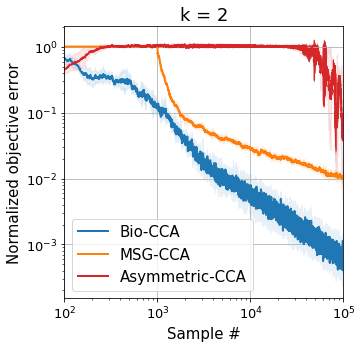

In [58]:
alg_error = pkl.load(open(f'error/{dataset}_{z_dim}-dim_objective_error.p', 'rb'))

linewidth = 2

t = list(range(iters))

fig = plt.figure(figsize=(5,5))

ax = plt.subplot(1, 1, 1)

for alg in algorithms:
    if alg!='Bio-RRR':
        add_fill_lines(ax, t, alg_error[alg], plot_kwargs={'ls': '-', 'lw': linewidth, 'label': alg, 'color': colors[alg]}, ci_kwargs={'color': colors[alg]})

ax.loglog()

plt.title(f"k = {z_dim}")
plt.grid()
plt.legend(loc = 'lower left')
plt.xlim((1e2,iters))
plt.xlabel('Sample #')
plt.ylabel('Normalized objective error')

plt.savefig(f'plots/{dataset}_{z_dim}-dim_objective_iterate.png', dpi=300, transparent='true', bbox_inches='tight')

##### Runtime comparison

/Users/dlipshutz/src/bio-cca/util.py:152: RuntimeWarning: invalid value encountered in log
  log_err = np.log(err+10**-5) # add 10**-5 to ensure the logarithm is well defined


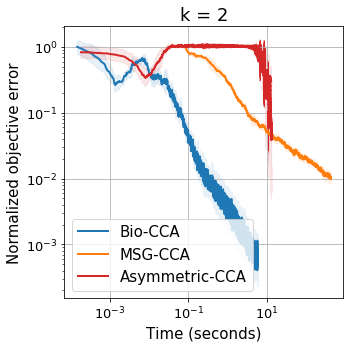

In [65]:
alg_error = pkl.load(open(f'error/{dataset}_{z_dim}-dim_objective_error.p', 'rb'))
alg_time = pkl.load(open(f'error/{dataset}_{z_dim}-dim_time.p', 'rb'))

linewidth = 2

fig = plt.figure(figsize=(5,5))

ax = plt.subplot(1, 1, 1)

for alg in algorithms:
    if alg!='Bio-RRR':
        add_fill_lines(ax, np.mean(alg_time[alg],axis=0), alg_error[alg], plot_kwargs={'ls': '-', 'lw': linewidth, 'label': alg, 'color': colors[alg]}, ci_kwargs={'color': colors[alg]})

ax.loglog()

plt.title(f"k = {z_dim}")
plt.grid()
plt.legend(loc = 'lower left')
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized objective error')

plt.savefig(f'plots/{dataset}_{z_dim}-dim_objective_runtime.png', dpi=300, transparent='true', bbox_inches='tight')

##### Per iterate comparison (subspace error)

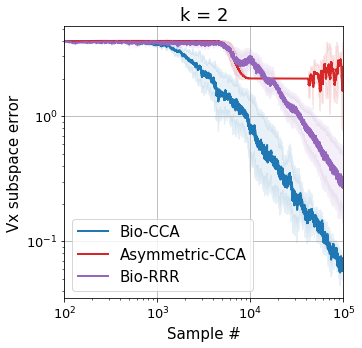

In [60]:
alg_subspacex_error = pkl.load(open(f'error/{dataset}_{z_dim}-dim_subspacex_error.p', 'rb'))

linewidth = 2

t = list(range(iters))

fig = plt.figure(figsize=(5,5))

ax = plt.subplot(1, 1, 1)

for alg in algorithms:
    if alg!='MSG-CCA':
        add_fill_lines(ax, t, alg_subspacex_error[alg], plot_kwargs={'ls': '-', 'lw': linewidth, 'label': alg, 'color': colors[alg]}, ci_kwargs={'color': colors[alg]})

ax.loglog()

plt.title(f"k = {z_dim}")
plt.grid()
plt.legend(loc = 'lower left')
plt.xlim((1e2,iters))
plt.xlabel('Sample #')
plt.ylabel('Vx subspace error')

plt.savefig(f'plots/{dataset}_{z_dim}-dim_subspacex_iterate.png', dpi=300, transparent='true', bbox_inches='tight')

##### Runtime comparison

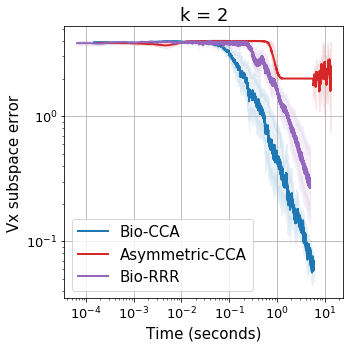

In [61]:
alg_subspacex_error = pkl.load(open(f'error/{dataset}_{z_dim}-dim_subspacex_error.p', 'rb'))
alg_time = pkl.load(open(f'error/{dataset}_{z_dim}-dim_time.p', 'rb'))

linewidth = 2

fig = plt.figure(figsize=(5,5))

ax = plt.subplot(1, 1, 1)

for alg in algorithms:
    if alg!='MSG-CCA':
        add_fill_lines(ax, np.mean(alg_time[alg],axis=0), alg_subspacex_error[alg], plot_kwargs={'ls': '-', 'lw': linewidth, 'label': alg, 'color': colors[alg]}, ci_kwargs={'color': colors[alg]})

ax.loglog()

plt.title(f"k = {z_dim}")
plt.grid()
plt.legend(loc = 'lower left')
plt.xlabel('Time (seconds)')
plt.ylabel('Vx subspace error')

plt.savefig(f'plots/{dataset}_{z_dim}-dim_subspacex_runtime.png', dpi=300, transparent='true', bbox_inches='tight')